In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %%bash
# set -m
# git clone https://github.com/sachdevkartik/DeepLense.git
# cd DeepLense && git checkout kartik_contribution
# cd ..
# mv DeepLense/Transformers_Classification_DeepLense_Kartik_Sachdev/* .
# rm -rf DeepLense

In [3]:
# %%bash
# pwd

In [4]:
# !nvidia-smi

In [5]:
# %%bash
# pip3 install --upgrade -r requirements.txt

In [6]:
# !pip uninstall numpy

In [7]:
# !pip install numpy

In [8]:
from __future__ import print_function
import os
import time
import copy
import json
import yaml

import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torchvision
from typing import *

In [9]:
from utils.util import *
from config.data_config import DATASET
from utils.dataset import DefaultDatasetSetupSSL
from self_supervised.losses.contrastive_loss import (
    ContrastiveLossEuclidean,
    ContrastiveLossEmbedding,
    SimCLR_Loss,
    NegativeCosineSimilarity,
)
from self_supervised.losses.sym_neg_cos_sim_loss import SymNegCosineSimilarityLoss

from models.modules.head import BYOLProjectionHead, BYOLPredictionHead
from utils.scheduler import cosine_schedule
from torch.utils.data import DataLoader, random_split
from einops.layers.torch import Rearrange


In [10]:
args = {
    "dataset_name": "Model_II",
    "save": "", # "content"
    # "extracted_dir": "", 
    "num_workers": 8,
    "train_config_path": "self_supervised/config/resnet_byol.yaml",
    "cuda": True,
    "log_dir": "logger"
}

In [11]:
batch_size = 16

dataset_name = args["dataset_name"]
dataset_dir = args["save"]
use_cuda = args["cuda"]
num_workers = args["num_workers"]
train_config_path = args["train_config_path"]
log_dir_base = args["log_dir"]
extracted_dir = args.get("extracted_dir", dataset_dir)

In [12]:
classes = DATASET[f"{dataset_name}"]["classes"]
num_classes = len(classes)

# Open the YAML file and load its contents
with open(train_config_path, "r") as file:
    train_config = yaml.safe_load(file)

In [13]:
learning_rate = train_config["optimizer_config"]["lr"]
margin = train_config["ssl"]["margin"]
num_channels = train_config["channels"]
temperature = train_config["ssl"]["temperature"]
network_type = train_config["network_type"]
image_size = train_config["image_size"]
optimizer_config = train_config["optimizer_config"]

backbone = train_config["backbone"]

make_directories([dataset_dir, extracted_dir])
seed_everything(seed=42)


# logging
current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
log_dir = f"{log_dir_base}/{current_time}"
init_logging_handler(log_dir_base, current_time)

# dump config in logger
with open(f"{log_dir}/config.json", "w") as fp:
    json.dump(train_config, fp)

# saving model path location
model_path_pretrained = os.path.join(
    f"{log_dir}/checkpoint",
    f"{network_type}_pretrained_{dataset_name}_{current_time}.pt",
)

model_path_finetune = os.path.join(
    f"{log_dir}/checkpoint",
    f"{network_type}_finetune_{dataset_name}_{current_time}.pt",
)

In [14]:
# paths
finetuned_model_path = os.path.join(f"{log_dir}/checkpoint", f"Resnet_dino_finetuned_{dataset_name}_{current_time}.pt")

In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


class DINOTransform:
    """Implements the global and local view augmentations for DINO [0].
    """

    def __init__(self):
        pass
    
    def get_transforms(self, 
                       global_crop_size: int = 224,
                       global_crop_scale: Tuple[float, float] = (0.4, 1.0),
                       local_crop_size: int = 96,
                       local_crop_scale: Tuple[float, float] = (0.05, 0.4),):

        # first global crop
        global_transform_0 = A.Compose(
        [
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            A.Resize(global_crop_size, global_crop_size, p=1.0),
            A.augmentations.GaussianBlur(),
            ToTensorV2(),
        ])

        # second global crop
        global_transform_1 = A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.25),
            A.Resize(global_crop_size, global_crop_size, p=1.0),
            A.augmentations.GaussNoise(var_limit=(0.002, 0.005), p=0.3),
            ToTensorV2(),
        ])
        
        # transformation for the local small crops
        local_transform = A.Compose(
        [
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            A.Resize(local_crop_size, local_crop_size, p=1.0),
            A.augmentations.GaussianBlur(),
            ToTensorV2(),
        ])
        return [global_transform_0, global_transform_1, local_transform]
    

In [16]:
from utils.dataset import visualize_samples_ssl, DeepLenseDatasetSSL

In [17]:
home = os.getenv("HOME")
data_dir = home + "/git/DeepLense/Transformers_Classification_DeepLense_Kartik_Sachdev/data" 

Model_II dataset already exists
train data: 89104


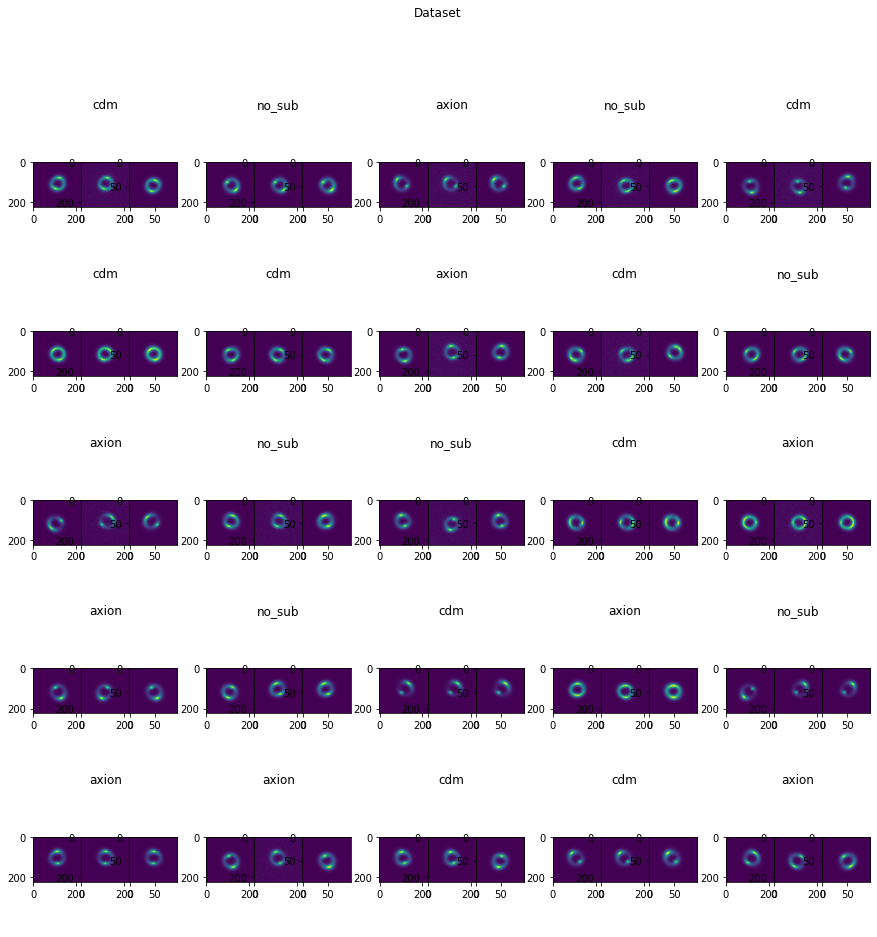

In [18]:
# trainset
dino_transform = DINOTransform()
train_transforms = dino_transform.get_transforms()
train_dataset = DeepLenseDatasetSSL(destination_dir = data_dir, transforms = train_transforms, mode="train", dataset_name=dataset_name, download=True, channels=1, extracted_dir= extracted_dir)
print(f"train data: {len(train_dataset)}")
visualize_samples_ssl(train_dataset, labels_map=classes, num_rows_inner=1, num_cols_inner=3)

In [19]:
# split in train and valid set
split_ratio = 0.25  # 0.25
valid_len = int(split_ratio * len(train_dataset))
train_len = len(train_dataset) - valid_len

train_dataset, val_set = random_split(train_dataset, [train_len, valid_len])

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

val_loader = DataLoader(
    dataset=val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

# Load test dataset
# testset = default_dataset_setup.get_dataset(mode="val")
# test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=True)

# size check
sample = next(iter(train_loader))
print("num of classes: ", num_classes)
print(sample[0].shape)

num of classes:  3
torch.Size([16, 1, 224, 224])


In [20]:
from lightly.loss import DINOLoss
from lightly.models.modules import DINOProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.dino_transform import DINOTransform
from lightly.utils.scheduler import cosine_schedule

In [21]:
class DINO(torch.nn.Module):
    def __init__(self, backbone, input_dim):
        super().__init__()

        self.backbone = backbone
        self.backbone[0] = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )

        self.student_backbone = self.backbone
        self.student_head = DINOProjectionHead(
            input_dim, 512, 64, 2048, freeze_last_layer=1
        )
        self.teacher_backbone = copy.deepcopy(self.backbone)
        self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
        deactivate_requires_grad(self.teacher_backbone)
        deactivate_requires_grad(self.teacher_head)

    def forward(self, x):
        y = self.student_backbone(x).flatten(start_dim=1)
        z = self.student_head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z

In [22]:
class DINOTransformer(torch.nn.Module):
    def __init__(self, backbone, input_dim):
        super().__init__()

        self.backbone = backbone

        self.student_backbone = self.backbone
        self.student_head = DINOProjectionHead(
            input_dim, 512, 64, 512, freeze_last_layer=1
        )
        self.teacher_backbone = copy.deepcopy(self.backbone)
        self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 512)
        deactivate_requires_grad(self.teacher_backbone)
        deactivate_requires_grad(self.teacher_head)

    def forward(self, x):
        y = self.student_backbone(x).flatten(start_dim=1)
        z = self.student_head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z

In [23]:
# # Create ResNet pretrain model
# resnet = torchvision.models.resnet34()
# backbone = nn.Sequential(*list(resnet.children())[:-1])

num_ftrs_dict = {
    "resnet18": 512,
    "resnet34": 512,
    "resnet50": 2048,

}

# model =  DINO(backbone, input_dim=num_ftrs_dict["resnet34"])
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# summary(model, input_size=(2, 1, 224, 224), device="cuda")

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Create Transformer pretrain model
from config.cvt_config import CvT_CONFIG
from models.transformer_zoo import TransformerModels

# Create pretrain model
transformer_config = CvT_CONFIG

in_features = 128
# Transformer model
transformer = TransformerModels(
    transformer_type=transformer_config["network_type"],
    num_channels=train_config["channels"],
    num_classes=in_features,
    img_size=image_size,
    **transformer_config["network_config"],
)


model = DINOTransformer(transformer, input_dim=in_features)
summary(model, input_size=(2, 1, 224, 224), device="cuda")

In [26]:
epochs_pretrain = 10

In [27]:
import math
from transformers import get_cosine_schedule_with_warmup

#optimizer
optimizer_pretrain = optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-4)
warmup_epochs = 3
num_train_steps = math.ceil(len(train_loader))
num_warmup_steps= num_train_steps * warmup_epochs
num_training_steps=int(num_train_steps * epochs_pretrain)

#learning rate scheduler
cosine_scheduler = get_cosine_schedule_with_warmup(optimizer_pretrain,num_warmup_steps = num_warmup_steps,num_training_steps =num_training_steps) 

DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


In [28]:
criterion_pretrain = DINOLoss(
    output_dim=512,
    warmup_teacher_temp_epochs=5,
)
# move loss to correct device because it also contains parameters
criterion_pretrain = criterion_pretrain.to(device)


In [29]:
print("Starting Training")
for epoch in range(epochs_pretrain):
    total_loss = 0
    best_loss = float("inf")

    momentum_val = cosine_schedule(epoch, epochs_pretrain, 0.996, 1)
    for batch_idx, batch in enumerate(train_loader):
        views = batch[:3]
        
        update_momentum(model.student_backbone, model.teacher_backbone, m=momentum_val)
        update_momentum(model.student_head, model.teacher_head, m=momentum_val)
        views = [view.to(device) for view in views]
        global_views = views[:2]
        teacher_out = [model.forward_teacher(view) for view in global_views]
        student_out = [model.forward(view) for view in views]
        loss = criterion_pretrain(teacher_out, student_out, epoch=epoch)
        total_loss += loss.detach()
        loss.backward()
        # We only cancel gradients of student head.
        model.student_head.cancel_last_layer_gradients(current_epoch=epoch)
        optimizer_pretrain.step()
        optimizer_pretrain.zero_grad()
        cosine_scheduler.step()

        if batch_idx % 10 == 0:
            print(
                f"Epoch [{epoch}/{epochs_pretrain}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item()}"
            )

    if total_loss < best_loss:
        best_loss = total_loss

        torch.save(model.state_dict(), model_path_pretrained)

    avg_loss = total_loss / len(train_loader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")


Starting Training
Epoch [0/10], Batch [0/4177], Loss: 7.048252105712891
Epoch [0/10], Batch [10/4177], Loss: 7.070061206817627
Epoch [0/10], Batch [20/4177], Loss: 6.915554046630859
Epoch [0/10], Batch [30/4177], Loss: 7.063720703125
Epoch [0/10], Batch [40/4177], Loss: 7.054387092590332
Epoch [0/10], Batch [50/4177], Loss: 6.988966941833496
Epoch [0/10], Batch [60/4177], Loss: 6.986783981323242
Epoch [0/10], Batch [70/4177], Loss: 6.938573837280273
Epoch [0/10], Batch [80/4177], Loss: 6.910792827606201
Epoch [0/10], Batch [90/4177], Loss: 6.886181831359863
Epoch [0/10], Batch [100/4177], Loss: 6.848036289215088
Epoch [0/10], Batch [110/4177], Loss: 6.71958065032959
Epoch [0/10], Batch [120/4177], Loss: 6.742104530334473
Epoch [0/10], Batch [130/4177], Loss: 6.686837196350098
Epoch [0/10], Batch [140/4177], Loss: 6.591501712799072
Epoch [0/10], Batch [150/4177], Loss: 6.509787082672119
Epoch [0/10], Batch [160/4177], Loss: 6.660402774810791
Epoch [0/10], Batch [170/4177], Loss: 6.56082

KeyboardInterrupt: 

In [ ]:
class FinetuneClassifier(nn.Module):
    def __init__(self, backbone, head):
        super(FinetuneClassifier, self).__init__()

        deactivate_requires_grad(backbone)
        self.backbone = backbone
        self.pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.rearrange = Rearrange("... () () -> ...")
        self.head = head

    def forward(self, x):
        z = self.backbone(x)
        z = self.pool(z)
        z = self.rearrange(z)
        z = self.head(z)
        return z

In [ ]:
# del model
# import gc
# gc.collect()
# torch.cuda.empty_cache()
# print(torch.cuda.memory_allocated())

In [ ]:
# load model
# model =  DINO(backbone, input_dim=num_ftrs_dict["resnet34"])
# model.load_state_dict(torch.load(model_path_pretrained))

In [ ]:
backbone = nn.Sequential(*list(model.backbone.children())[:-1])

classification_head = nn.Sequential(
    nn.Linear(num_ftrs_dict["resnet34"], 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, num_classes),)

In [ ]:
finetune_model = FinetuneClassifier(backbone, classification_head)
finetune_model.to(device)

summary(finetune_model, input_size=(1, 1, 224, 224), device="cuda")

In [ ]:
learning_rate = 3e-4
weight_decay =  0.01

finetune_optimizer = optim.AdamW(
    finetune_model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
)

finetune_epochs = 1

In [ ]:
finetune_criterion = nn.CrossEntropyLoss()

In [ ]:
def finetune(
    epochs: int,
    model: nn.Module,
    device: Union[int, str],
    train_loader: Any,
    criterion: nn.Module,
    optimizer: nn.Module,
    saved_model_path: str,
    valid_loader: Any,
):
    best_loss = float("inf")
    all_val_loss = []
    all_val_accuracy = []

    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0.0
        model.train()

        for batch_idx, batch in enumerate(train_loader): # for batch_idx, batch in enumerate(train_loader):
            img1 = batch[0].to(device)
            label = batch[-1].to(device)
            optimizer.zero_grad()
            output = model(img1)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss

            if batch_idx % 10 == 0:
                print(
                    f"Epoch [{epoch}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item()}"
                )

        epoch_loss = epoch_loss / len(train_loader)

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            # best_model = copy.deepcopy(model)
            torch.save(model.state_dict(), saved_model_path)
            print("====== Model saved ======")

        with torch.no_grad():
            print("====== Eval started ======")
            model.eval()
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for batch_idx, batch in enumerate(train_loader): # for batch_idx, batch in enumerate(train_loader):
                data = batch[0,1].to(device)
                label = batch[-1].to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc
                epoch_val_loss += val_loss

            epoch_val_accuracy = epoch_val_accuracy / len(valid_loader)
            epoch_val_loss = epoch_val_loss / len(valid_loader)
            all_val_loss.append(epoch_val_loss)

        all_val_accuracy.append(epoch_val_accuracy.item() * 100)

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} \n"
        )

In [ ]:
# Training loop
finetune(
    finetune_epochs,
    finetune_model,
    device,
    train_loader,
    finetune_criterion,
    finetune_optimizer,
    finetuned_model_path,
    valid_loader=val_loader,
)

# New Section